## Q learning

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from tabular_Q.env import *
from tabular_Q.Q_table import *

Load data

In [75]:
# data proccess
DATA_PATH = './per_min_data/'

data = pd.read_csv(DATA_PATH + os.listdir(DATA_PATH)[0])

data.iloc[:,6] = pd.to_datetime(data.iloc[:,6], unit='ms').apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
data.iloc[:,6] = pd.to_datetime(data.iloc[:,6])
data.set_index('Close time', inplace=True)
data = data.iloc[:,1:6]
# Aggregate per hour
data = data.resample('60T').agg({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Close':'last',
    'Volume':'sum'
    })
data = data.dropna() 

In [76]:
data

,Open,High,Low,Close,Volume
Close time,,,,,
2018-04-27 14:00:00,9226.97,9290.00,9202.00,9288.88,1401.058675
2018-04-27 15:00:00,9280.14,9288.88,9210.01,9241.21,1359.959170
2018-04-27 16:00:00,9241.20,9328.26,9241.00,9282.10,1395.512101
2018-04-27 17:00:00,9286.01,9319.99,9266.00,9290.10,1122.230082
2018-04-27 18:00:00,9290.10,9296.31,9213.80,9230.89,1001.907142
2018-04-27 19:00:00,9230.89,9250.56,9075.01,9089.00,2097.185440
2018-04-27 20:00:00,9089.12,9163.38,8940.00,8970.00,3084.066108
2018-04-27 21:00:00,8969.99,9053.00,8909.83,8975.35,1911.233654
2018-04-27 22:00:00,8975.36,9093.09,8975.36,9031.00,1077.087976


Create environment and agent

In [98]:
env =  Market(data, episode_len = 100)
env.num_train = 5336 + 600
env.num_val = 600

number of train data:  6003 number of validation data:  667


In [99]:
agent = Q_table(env)

train agent

In [83]:
agent.train(1)

epoch 0...
    episode 0 with index 2818...
[0 0 0 1]
    episode 1 with index 2819...
[1 0 0 1]
    episode 2 with index 2820...
[1 0 0 2]
    episode 3 with index 2821...
[1 0 0 0]
    episode 4 with index 2822...
[1 0 0 1]
    episode 5 with index 2823...
[1 0 0 0]
    episode 6 with index 2824...
[1 0 0 0]
    episode 7 with index 2825...
[1 0 0 0]
    episode 8 with index 2826...
[1 0 0 0]
    episode 9 with index 2827...
[1 0 0 0]
    episode 10 with index 2828...
[1 0 0 1]
    episode 11 with index 2829...
[1 0 0 1]
    episode 12 with index 2830...
[1 0 0 1]
    episode 13 with index 2831...
[1 0 0 1]
    episode 14 with index 2832...
[1 0 0 1]
    episode 15 with index 2833...
[1 0 0 1]
    episode 16 with index 2834...
[1 1 0 1]
    episode 17 with index 2835...
[1 0 0 1]
    episode 18 with index 2836...
[1 0 0 2]
    episode 19 with index 2837...
[1 0 0 1]
    episode 20 with index 2838...
[2 1 0 1]
    episode 21 with index 2839...
[2 1 0 2]
    episode 22 with index 2840.

epoch 3...
    episode 0 with index 4697...
[0 0 0 0]
    episode 1 with index 4698...
[0 0 0 0]
    episode 2 with index 4699...
[0 0 0 0]
    episode 3 with index 4700...
[0 0 0 0]
    episode 4 with index 4701...
[0 0 0 0]
    episode 5 with index 4702...
[0 0 0 0]
    episode 6 with index 4703...
[0 0 0 0]
    episode 7 with index 4704...
[1 0 0 0]
    episode 8 with index 4705...
[1 0 0 0]
    episode 9 with index 4706...
[0 0 0 0]
    episode 10 with index 4707...
[1 1 0 0]
    episode 11 with index 4708...
[1 0 0 0]
    episode 12 with index 4709...
[0 0 0 0]
    episode 13 with index 4710...
[0 0 0 0]
    episode 14 with index 4711...
[1 0 0 0]
    episode 15 with index 4712...
[1 0 0 0]
    episode 16 with index 4713...
[1 0 0 0]
    episode 17 with index 4714...
[0 0 0 0]
    episode 18 with index 4715...
[0 0 0 0]
    episode 19 with index 4716...
[0 0 0 0]
    episode 20 with index 4717...
[0 0 0 0]
    episode 21 with index 4718...
[0 0 0 0]
    episode 22 with index 4719.

    episode 82 with index 1811...
[0 0 0 0]
    episode 83 with index 1812...
[0 0 0 1]
    episode 84 with index 1813...
[0 0 0 2]
    episode 85 with index 1814...
[0 0 0 2]
    episode 86 with index 1815...
[0 0 0 0]
    episode 87 with index 1816...
[0 0 0 1]
    episode 88 with index 1817...
[1 0 0 0]
    episode 89 with index 1818...
[0 0 0 1]
    episode 90 with index 1819...
[0 0 0 0]
    episode 91 with index 1820...
[0 0 0 0]
    episode 92 with index 1821...
[1 0 0 1]
    episode 93 with index 1822...
[0 0 0 0]
    episode 94 with index 1823...
[0 0 0 1]
    episode 95 with index 1824...
[0 0 0 1]
    episode 96 with index 1825...
[1 0 0 1]
    episode 97 with index 1826...
[1 0 0 1]
    episode 98 with index 1827...
[1 0 0 0]
epoch 7...
    episode 0 with index 3267...
[1 0 0 1]
    episode 1 with index 3268...
[0 0 0 2]
    episode 2 with index 3269...
[0 0 0 1]
    episode 3 with index 3270...
[0 0 0 0]
    episode 4 with index 3271...
[0 0 0 0]
    episode 5 with index 3

    episode 77 with index 2066...
[2 2 1 1]
    episode 78 with index 2067...
[2 2 1 1]
    episode 79 with index 2068...
[2 2 1 1]
    episode 80 with index 2069...
[2 2 1 1]
    episode 81 with index 2070...
[2 2 1 1]
    episode 82 with index 2071...
[2 2 1 1]
    episode 83 with index 2072...
[2 2 1 2]
    episode 84 with index 2073...
[2 2 1 2]
    episode 85 with index 2074...
[2 2 1 1]
    episode 86 with index 2075...
[2 2 1 0]
    episode 87 with index 2076...
[2 2 1 1]
    episode 88 with index 2077...
[2 2 1 1]
    episode 89 with index 2078...
[2 2 1 1]
    episode 90 with index 2079...
[2 2 1 1]
    episode 91 with index 2080...
[2 2 1 1]
    episode 92 with index 2081...
[2 2 1 2]
    episode 93 with index 2082...
[2 2 1 2]
    episode 94 with index 2083...
[2 2 2 2]
    episode 95 with index 2084...
[2 2 2 2]
    episode 96 with index 2085...
[2 2 2 2]
    episode 97 with index 2086...
[2 2 2 2]
    episode 98 with index 2087...
[2 2 2 1]
epoch 11...
    episode 0 with i

    episode 18 with index 5505...
[0 0 0 1]
    episode 19 with index 5506...
[0 0 0 0]
    episode 20 with index 5507...
[0 0 0 1]
    episode 21 with index 5508...
[0 0 0 1]
    episode 22 with index 5509...
[0 0 0 1]
    episode 23 with index 5510...
[0 0 0 1]
    episode 24 with index 5511...
[0 0 0 1]
    episode 25 with index 5512...
[0 0 0 1]
    episode 26 with index 5513...
[0 0 0 1]
    episode 27 with index 5514...
[0 0 0 1]
    episode 28 with index 5515...
[0 0 0 1]
    episode 29 with index 5516...
[0 0 0 2]
    episode 30 with index 5517...
[0 0 0 2]
    episode 31 with index 5518...
[0 0 0 1]
    episode 32 with index 5519...
[0 0 0 1]
    episode 33 with index 5520...
[0 0 0 1]
    episode 34 with index 5521...
[0 0 0 2]
    episode 35 with index 5522...
[0 0 0 2]
    episode 36 with index 5523...
[0 0 0 1]
    episode 37 with index 5524...
[0 0 0 1]
    episode 38 with index 5525...
[0 0 0 0]
    episode 39 with index 5526...
[0 0 0 0]
    episode 40 with index 5527..

/home/xywang/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/xywang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/xywang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/xywang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/xywang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    episode 30 with index 2836...
[1 0 0 2]
    episode 31 with index 2837...
[1 0 0 1]
    episode 32 with index 2838...
[2 1 0 1]
    episode 33 with index 2839...
[2 1 0 2]
    episode 34 with index 2840...
[2 1 0 2]
    episode 35 with index 2841...
[2 1 0 1]
    episode 36 with index 2842...
[2 1 0 1]
    episode 37 with index 2843...
[2 1 0 2]
    episode 38 with index 2844...
[2 1 0 1]
    episode 39 with index 2845...
[2 1 0 1]
    episode 40 with index 2846...
[2 1 0 1]
    episode 41 with index 2847...
[2 1 0 0]
    episode 42 with index 2848...
[2 1 0 1]
    episode 43 with index 2849...
[2 1 0 0]
    episode 44 with index 2850...
[2 1 0 1]
    episode 45 with index 2851...
[2 1 0 0]
    episode 46 with index 2852...
[2 1 0 0]
    episode 47 with index 2853...
[2 1 0 0]
    episode 48 with index 2854...
[2 1 0 0]
    episode 49 with index 2855...
[2 1 0 0]
    episode 50 with index 2856...
[2 1 0 0]
    episode 51 with index 2857...
[2 1 0 0]
    episode 52 with index 2858..

    episode 89 with index 2896...
[1 1 0 0]
    episode 90 with index 2897...
[1 1 0 0]
    episode 91 with index 2898...
[2 1 0 1]
    episode 92 with index 2899...
[2 1 0 1]
    episode 93 with index 2900...
[2 1 0 1]
    episode 94 with index 2901...
[2 1 0 1]
    episode 95 with index 2902...
[1 1 0 1]
    episode 96 with index 2903...
[1 1 0 0]
    episode 97 with index 2904...
[2 1 0 0]
    episode 98 with index 2905...
[2 1 0 1]
epoch 19...
    episode 0 with index 1685...
[1 0 0 0]
    episode 1 with index 1686...
[1 0 0 0]
    episode 2 with index 1687...
[1 0 0 0]
    episode 3 with index 1688...
[1 0 0 0]
    episode 4 with index 1689...
[0 0 0 0]
    episode 5 with index 1690...
[0 0 0 0]
    episode 6 with index 1691...
[0 0 0 0]
    episode 7 with index 1692...
[2 0 0 1]
    episode 8 with index 1693...
[2 0 0 2]
    episode 9 with index 1694...
[2 0 0 2]
    episode 10 with index 1695...
[2 0 0 1]
    episode 11 with index 1696...
[2 0 0 1]
    episode 12 with index 1697

[1 1 0 0]
    episode 89 with index 3569...
[1 1 0 0]
    episode 90 with index 3570...
[1 1 0 0]
    episode 91 with index 3571...
[0 1 0 0]
    episode 92 with index 3572...
[0 1 0 2]
    episode 93 with index 3573...
[0 1 0 1]
    episode 94 with index 3574...
[0 1 0 1]
    episode 95 with index 3575...
[0 1 0 2]
    episode 96 with index 3576...
[0 1 0 1]
    episode 97 with index 3577...
[0 1 0 2]
    episode 98 with index 3578...
[0 1 0 1]
epoch 22...
    episode 0 with index 3982...
[0 0 0 1]
    episode 1 with index 3983...
[0 0 0 1]
    episode 2 with index 3984...
[0 0 0 0]
    episode 3 with index 3985...
[0 0 0 1]
    episode 4 with index 3986...
[0 0 0 1]
    episode 5 with index 3987...
[0 0 0 2]
    episode 6 with index 3988...
[0 0 0 1]
    episode 7 with index 3989...
[0 0 0 1]
    episode 8 with index 3990...
[0 0 0 1]
    episode 9 with index 3991...
[0 0 0 1]
    episode 10 with index 3992...
[0 0 0 0]
    episode 11 with index 3993...
[0 0 0 0]
    episode 12 with 

    episode 56 with index 2913...
[2 1 0 1]
    episode 57 with index 2914...
[2 1 0 1]
    episode 58 with index 2915...
[2 1 0 0]
    episode 59 with index 2916...
[2 1 0 0]
    episode 60 with index 2917...
[2 1 1 2]
    episode 61 with index 2918...
[2 1 1 1]
    episode 62 with index 2919...
[2 1 1 2]
    episode 63 with index 2920...
[2 1 0 2]
    episode 64 with index 2921...
[2 1 0 1]
    episode 65 with index 2922...
[2 1 1 1]
    episode 66 with index 2923...
[2 1 1 1]
    episode 67 with index 2924...
[2 1 1 1]
    episode 68 with index 2925...
[2 1 1 1]
    episode 69 with index 2926...
[2 1 1 1]
    episode 70 with index 2927...
[2 1 1 1]
    episode 71 with index 2928...
[2 1 1 1]
    episode 72 with index 2929...
[2 1 1 2]
    episode 73 with index 2930...
[2 1 1 1]
    episode 74 with index 2931...
[2 1 1 2]
    episode 75 with index 2932...
[2 1 1 2]
    episode 76 with index 2933...
[2 1 1 2]
    episode 77 with index 2934...
[2 1 1 2]
    episode 78 with index 2935..

epoch 27...
    episode 0 with index 4839...
[0 0 0 2]
    episode 1 with index 4840...
[0 0 0 2]
    episode 2 with index 4841...
[0 0 0 2]
    episode 3 with index 4842...
[0 0 0 2]
    episode 4 with index 4843...
[0 0 0 2]
    episode 5 with index 4844...
[0 0 0 2]
    episode 6 with index 4845...
[0 0 0 1]
    episode 7 with index 4846...
[0 0 0 1]
    episode 8 with index 4847...
[0 0 0 1]
    episode 9 with index 4848...
[0 0 0 2]
    episode 10 with index 4849...
[0 0 0 2]
    episode 11 with index 4850...
[0 0 0 2]
    episode 12 with index 4851...
[0 0 0 2]
    episode 13 with index 4852...
[0 0 0 1]
    episode 14 with index 4853...
[0 0 0 1]
    episode 15 with index 4854...
[0 0 0 1]
    episode 16 with index 4855...
[0 0 0 1]
    episode 17 with index 4856...
[0 0 0 1]
    episode 18 with index 4857...
[0 0 0 1]
    episode 19 with index 4858...
[0 0 0 1]
    episode 20 with index 4859...
[0 0 0 1]
    episode 21 with index 4860...
[0 0 0 1]
    episode 22 with index 4861

    episode 82 with index 2572...
[2 0 0 1]
    episode 83 with index 2573...
[1 0 0 2]
    episode 84 with index 2574...
[1 0 0 2]
    episode 85 with index 2575...
[0 0 0 2]
    episode 86 with index 2576...
[0 0 0 2]
    episode 87 with index 2577...
[0 0 0 2]
    episode 88 with index 2578...
[1 0 0 2]
    episode 89 with index 2579...
[0 0 0 1]
    episode 90 with index 2580...
[0 0 0 1]
    episode 91 with index 2581...
[0 0 0 1]
    episode 92 with index 2582...
[0 0 0 2]
    episode 93 with index 2583...
[0 0 0 2]
    episode 94 with index 2584...
[0 0 0 2]
    episode 95 with index 2585...
[0 0 0 2]
    episode 96 with index 2586...
[0 0 0 2]
    episode 97 with index 2587...
[0 0 0 1]
    episode 98 with index 2588...
[0 0 0 2]
epoch 31...
    episode 0 with index 1737...
[1 0 0 0]
    episode 1 with index 1738...
[1 0 0 0]
    episode 2 with index 1739...
[2 0 0 0]
    episode 3 with index 1740...
[1 0 0 2]
    episode 4 with index 1741...
[1 0 0 2]
    episode 5 with index 

    episode 23 with index 4409...
[0 1 1 0]
    episode 24 with index 4410...
[0 1 1 0]
    episode 25 with index 4411...
[1 1 1 0]
    episode 26 with index 4412...
[0 1 0 0]
    episode 27 with index 4413...
[0 1 0 0]
    episode 28 with index 4414...
[0 0 0 2]
    episode 29 with index 4415...
[0 0 0 2]
    episode 30 with index 4416...
[0 0 0 1]
    episode 31 with index 4417...
[0 0 0 0]
    episode 32 with index 4418...
[0 0 0 0]
    episode 33 with index 4419...
[0 0 0 0]
    episode 34 with index 4420...
[0 0 0 0]
    episode 35 with index 4421...
[0 0 0 0]
    episode 36 with index 4422...
[0 0 0 0]
    episode 37 with index 4423...
[0 0 0 0]
    episode 38 with index 4424...
[0 0 0 0]
    episode 39 with index 4425...
[0 0 0 0]
    episode 40 with index 4426...
[0 0 0 0]
    episode 41 with index 4427...
[0 0 0 0]
    episode 42 with index 4428...
[0 0 0 0]
    episode 43 with index 4429...
[0 0 0 0]
    episode 44 with index 4430...
[0 0 0 0]
    episode 45 with index 4431..

epoch 36...
    episode 0 with index 5156...
[2 0 0 2]
    episode 1 with index 5157...
[2 0 0 2]
    episode 2 with index 5158...
[2 0 0 2]
    episode 3 with index 5159...
[2 0 0 2]
    episode 4 with index 5160...
[2 0 0 2]
    episode 5 with index 5161...
[2 0 0 2]
    episode 6 with index 5162...
[2 0 0 1]
    episode 7 with index 5163...
[2 0 0 1]
    episode 8 with index 5164...
[2 0 0 2]
    episode 9 with index 5165...
[2 0 0 1]
    episode 10 with index 5166...
[2 0 0 2]
    episode 11 with index 5167...
[2 0 0 2]
    episode 12 with index 5168...
[2 0 0 1]
    episode 13 with index 5169...
[2 0 0 2]
    episode 14 with index 5170...
[2 0 0 1]
    episode 15 with index 5171...
[1 0 0 2]
    episode 16 with index 5172...
[1 0 0 2]
    episode 17 with index 5173...
[1 0 0 2]
    episode 18 with index 5174...
[0 0 0 2]
    episode 19 with index 5175...
[0 0 0 2]
    episode 20 with index 5176...
[0 0 0 2]
    episode 21 with index 5177...
[0 0 0 2]
    episode 22 with index 5178

    episode 91 with index 3641...
[2 0 0 0]
    episode 92 with index 3642...
[1 0 0 0]
    episode 93 with index 3643...
[1 0 0 0]
    episode 94 with index 3644...
[1 0 0 0]
    episode 95 with index 3645...
[1 0 0 0]
    episode 96 with index 3646...
[1 0 0 0]
    episode 97 with index 3647...
[1 0 0 1]
    episode 98 with index 3648...
[1 0 0 1]
epoch 39...
    episode 0 with index 4256...
[0 1 1 1]
    episode 1 with index 4257...
[0 1 1 0]
    episode 2 with index 4258...
[0 1 1 0]
    episode 3 with index 4259...
[0 1 1 0]
    episode 4 with index 4260...
[0 1 1 0]
    episode 5 with index 4261...
[0 1 1 0]
    episode 6 with index 4262...
[0 1 1 0]
    episode 7 with index 4263...
[0 1 1 0]
    episode 8 with index 4264...
[0 1 1 0]
    episode 9 with index 4265...
[0 1 1 0]
    episode 10 with index 4266...
[0 1 1 0]
    episode 11 with index 4267...
[0 1 1 0]
    episode 12 with index 4268...
[0 1 1 1]
    episode 13 with index 4269...
[0 1 1 1]
    episode 14 with index 4270

    episode 79 with index 5171...
[1 0 0 2]
    episode 80 with index 5172...
[1 0 0 2]
    episode 81 with index 5173...
[1 0 0 2]
    episode 82 with index 5174...
[0 0 0 2]
    episode 83 with index 5175...
[0 0 0 2]
    episode 84 with index 5176...
[0 0 0 2]
    episode 85 with index 5177...
[0 0 0 2]
    episode 86 with index 5178...
[0 0 0 2]
    episode 87 with index 5179...
[0 0 0 2]
    episode 88 with index 5180...
[0 0 0 2]
    episode 89 with index 5181...
[0 0 0 1]
    episode 90 with index 5182...
[0 0 0 1]
    episode 91 with index 5183...
[0 0 0 1]
    episode 92 with index 5184...
[0 0 0 1]
    episode 93 with index 5185...
[0 0 0 2]
    episode 94 with index 5186...
[0 0 0 2]
    episode 95 with index 5187...
[0 0 0 1]
    episode 96 with index 5188...
[0 0 0 1]
    episode 97 with index 5189...
[0 0 0 1]
    episode 98 with index 5190...
[0 0 0 1]
epoch 42...
    episode 0 with index 2009...
[0 2 1 1]
    episode 1 with index 2010...
[0 2 1 1]
    episode 2 with ind

    episode 65 with index 213...
[0 1 2 1]
    episode 66 with index 214...
[0 1 2 1]
    episode 67 with index 215...
[0 1 2 1]
    episode 68 with index 216...
[0 1 2 1]
    episode 69 with index 217...
[0 1 2 1]
    episode 70 with index 218...
[0 1 2 1]
    episode 71 with index 219...
[0 1 2 1]
    episode 72 with index 220...
[0 1 2 1]
    episode 73 with index 221...
[0 1 2 1]
    episode 74 with index 222...
[0 1 2 1]
    episode 75 with index 223...
[0 1 2 1]
    episode 76 with index 224...
[0 1 1 1]
    episode 77 with index 225...
[0 1 1 1]
    episode 78 with index 226...
[0 1 1 1]
    episode 79 with index 227...
[0 1 1 1]
    episode 80 with index 228...
[0 1 1 1]
    episode 81 with index 229...
[0 1 1 1]
    episode 82 with index 230...
[0 1 1 1]
    episode 83 with index 231...
[0 1 1 1]
    episode 84 with index 232...
[0 1 1 1]
    episode 85 with index 233...
[0 1 1 1]
    episode 86 with index 234...
[0 1 1 1]
    episode 87 with index 235...
[0 1 1 1]
    episode

epoch 47...
    episode 0 with index 4236...
[2 1 1 0]
    episode 1 with index 4237...
[1 1 1 1]
    episode 2 with index 4238...
[1 1 1 1]
    episode 3 with index 4239...
[2 1 1 1]
    episode 4 with index 4240...
[2 1 1 0]
    episode 5 with index 4241...
[2 1 1 0]
    episode 6 with index 4242...
[2 1 1 0]
    episode 7 with index 4243...
[0 1 1 0]
    episode 8 with index 4244...
[1 1 1 0]
    episode 9 with index 4245...
[1 1 1 0]
    episode 10 with index 4246...
[1 1 1 0]
    episode 11 with index 4247...
[0 1 1 0]
    episode 12 with index 4248...
[0 1 1 1]
    episode 13 with index 4249...
[0 1 1 0]
    episode 14 with index 4250...
[0 1 1 0]
    episode 15 with index 4251...
[0 1 1 0]
    episode 16 with index 4252...
[0 1 1 0]
    episode 17 with index 4253...
[0 1 1 0]
    episode 18 with index 4254...
[0 1 1 0]
    episode 19 with index 4255...
[0 1 1 0]
    episode 20 with index 4256...
[0 1 1 1]
    episode 21 with index 4257...
[0 1 1 0]
    episode 22 with index 4258

    episode 38 with index 2868...
[2 1 0 0]
    episode 39 with index 2869...
[2 1 0 0]
    episode 40 with index 2870...
[2 1 0 0]
    episode 41 with index 2871...
[2 1 0 0]
    episode 42 with index 2872...
[1 1 0 2]
    episode 43 with index 2873...
[1 1 0 1]
    episode 44 with index 2874...
[1 1 0 0]
    episode 45 with index 2875...
[1 1 0 0]
    episode 46 with index 2876...
[1 1 0 0]
    episode 47 with index 2877...
[1 1 0 0]
    episode 48 with index 2878...
[1 1 0 0]
    episode 49 with index 2879...
[1 1 0 0]
    episode 50 with index 2880...
[1 1 0 0]
    episode 51 with index 2881...
[2 1 0 1]
    episode 52 with index 2882...
[2 1 0 0]
    episode 53 with index 2883...
[2 1 0 0]
    episode 54 with index 2884...
[2 1 0 0]
    episode 55 with index 2885...
[1 1 0 0]
    episode 56 with index 2886...
[1 1 0 0]
    episode 57 with index 2887...
[1 1 0 0]
    episode 58 with index 2888...
[2 1 0 0]
    episode 59 with index 2889...
[2 1 0 0]
    episode 60 with index 2890..

    episode 18 with index 4804...
[0 0 0 2]
    episode 19 with index 4805...
[0 0 0 1]
    episode 20 with index 4806...
[0 0 0 2]
    episode 21 with index 4807...
[0 0 0 1]
    episode 22 with index 4808...
[0 0 0 2]
    episode 23 with index 4809...
[0 0 0 2]
    episode 24 with index 4810...
[0 0 0 1]
    episode 25 with index 4811...
[0 0 0 1]
    episode 26 with index 4812...
[0 0 0 1]
    episode 27 with index 4813...
[0 0 0 1]
    episode 28 with index 4814...
[0 0 0 2]
    episode 29 with index 4815...
[0 0 0 2]
    episode 30 with index 4816...
[0 0 0 1]
    episode 31 with index 4817...
[0 0 0 2]
    episode 32 with index 4818...
[0 0 0 2]
    episode 33 with index 4819...
[0 0 0 2]
    episode 34 with index 4820...
[0 0 0 2]
    episode 35 with index 4821...
[0 0 0 2]
    episode 36 with index 4822...
[0 0 0 1]
    episode 37 with index 4823...
[0 0 0 1]
    episode 38 with index 4824...
[0 0 0 1]
    episode 39 with index 4825...
[0 0 0 1]
    episode 40 with index 4826..

    episode 25 with index 3870...
[1 1 0 0]
    episode 26 with index 3871...
[1 1 0 0]
    episode 27 with index 3872...
[1 1 0 0]
    episode 28 with index 3873...
[1 1 0 0]
    episode 29 with index 3874...
[1 1 0 0]
    episode 30 with index 3875...
[1 1 0 0]
    episode 31 with index 3876...
[1 1 0 0]
    episode 32 with index 3877...
[1 1 0 0]
    episode 33 with index 3878...
[1 1 0 2]
    episode 34 with index 3879...
[1 1 0 0]
    episode 35 with index 3880...
[1 1 0 0]
    episode 36 with index 3881...
[1 1 0 0]
    episode 37 with index 3882...
[0 1 0 0]
    episode 38 with index 3883...
[1 1 0 0]
    episode 39 with index 3884...
[0 1 0 0]
    episode 40 with index 3885...
[0 1 0 0]
    episode 41 with index 3886...
[0 1 0 1]
    episode 42 with index 3887...
[0 1 0 0]
    episode 43 with index 3888...
[0 1 0 0]
    episode 44 with index 3889...
[0 1 0 1]
    episode 45 with index 3890...
[0 1 0 0]
    episode 46 with index 3891...
[0 1 0 0]
    episode 47 with index 3892..

    episode 63 with index 809...
[2 1 0 1]
    episode 64 with index 810...
[2 1 0 1]
    episode 65 with index 811...
[2 1 0 1]
    episode 66 with index 812...
[2 1 0 1]
    episode 67 with index 813...
[2 1 0 1]
    episode 68 with index 814...
[2 1 0 1]
    episode 69 with index 815...
[2 1 0 1]
    episode 70 with index 816...
[2 1 0 1]
    episode 71 with index 817...
[2 1 0 1]
    episode 72 with index 818...
[2 1 0 1]
    episode 73 with index 819...
[2 1 0 1]
    episode 74 with index 820...
[2 1 0 1]
    episode 75 with index 821...
[2 1 0 1]
    episode 76 with index 822...
[1 1 0 1]
    episode 77 with index 823...
[1 1 0 1]
    episode 78 with index 824...
[2 1 0 1]
    episode 79 with index 825...
[1 1 0 1]
    episode 80 with index 826...
[1 1 0 1]
    episode 81 with index 827...
[1 1 0 1]
    episode 82 with index 828...
[1 1 0 1]
    episode 83 with index 829...
[1 1 0 1]
    episode 84 with index 830...
[2 1 0 1]
    episode 85 with index 831...
[2 1 0 1]
    episode

Testing

In [84]:
sharpe, actions = agent.validation()

In [85]:
sharpe

0.05512332827955703

Sharpe ratio if all the actions are long

In [86]:
env.sharpe_ratio(range(env.num_train, env.num_train + env.num_val), np.ones(env.num_val))

-0.009819118260673568

Plot the cumulative rewards

In [87]:
a = np.array(actions[:-1])
ret = np.diff(np.log(env.data_raw[range(env.num_train, env.num_train + env.num_val)][:,3])) * a

In [88]:
import matplotlib.pyplot as plt

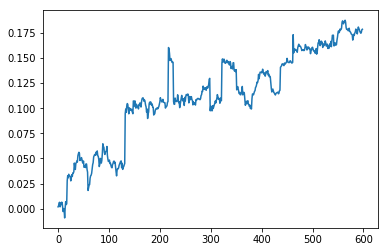

In [89]:
plt.plot(np.cumsum(np.array(ret)))